# Chapter 3: Journey to the Frozen Sea

<div class="alert alert-block alert-success">
<b>Objective</b> <br>
    Reproduce figures from the C3S Climate Intelligence reports about sea ice. Specifically, we will reproduce figures from Sea ice section of the the <a href="https://climate.copernicus.eu/climate-bulletins">Monthly Climate Bulletins</a> and <a href="https://climate.copernicus.eu/climate-indicators/sea-ice">Climate Indicators</a>.
 </a>
</div>


### Background

EUMETSAT is the European Organisation for the Exploitation of Meteorological Satellites. It's a global operational satellite agency at the heart of Europe that provides data, products, and support to a wide range of users in Europe and across the world.

The OSI SAF, or Ocean and Sea Ice Satellite Application Facility, is one of the specialized Satellite Application Facilities (SAFs) under EUMETSAT. The SAFs are dedicated centers of excellence for processing satellite data, and they focus on various thematic areas. OSI SAF, as its name suggests, concentrates on delivering operational products and services related to ocean and [sea ice](https://osi-saf.eumetsat.int/products/sea-ice-products).

In this tutorial we will work with different characteristics of global sea ice, specifically we will look at
* **Sea Ice Concentration (SIC)** is the fractional coverage of a grid cell that is covered with sea ice
* **Sea Ice Extent (SIE)** is the total area of all grid cells with at least 15% ice concentration.
* **Sea Ice Edge**:  The sea surface can be classified into open water, open ice, and closed ice depending on the amount of sea ice present in each grid cell. A sea ice concentration threshold of 30% is used to distinguish between open water and open ice.
* **Sea Ice Type**: Sea ice-covered areas are typically distinghuised by two categories based on the age of the sea ice: multiyear ice versus seasonal first-year ice.

Most of the datasets are provided by the [MET Norway Thredds Service](https://thredds.met.no/thredds/osisaf/osisaf.html) of the Norwegian Meteorological Institute except of the sea ice edge and type which is available only through the Climate Data Store (CDS). Whenever possible, we will access the data through the CDS. However, we also show how to obtain the data set directly from the official data provider in the case of sea ice extent.


### Overview Datasets

Throughout the notebook we will use the following datasets:

| Variable | Provider | Dataset | Climate Data Store |
|---------|:-------------:|:------:|:------:|  
| Sea ice concentration | EUMETSAT OSI SAF | [CDR v3.0](https://osi-saf.eumetsat.int/products/osi-430-a) (OSI-450-a) / [ICDR v3.0](https://osi-saf.eumetsat.int/products/osi-450-a) (OSI-430-a) | [Yes](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview) |
| Sea ice extent | EUMETSAT OSI SAF | [Sea Ice Index v2.2](https://osi-saf.eumetsat.int/products/osi-420) | No |
| Sea ice edge/type | C3S/CDS | -- | [Yes](https://doi.org/10.24381/cds.29c46d83)


<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ECMWFCode4Earth/sketchbook-earth/main?labpath=tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------

### Import Packages

In [1]:
import os
import glob
import cdsapi
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cmocean as cmo

import dask
import calendar

import matplotlib.dates as dates
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import seaborn as sns

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
from dask.diagnostics.progress import ProgressBar

In [2]:
plt.style.use("../copernicus.mplstyle")

In [3]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

### Getting Set Up

Set the reference period that defines the climatology of our records. Note that the format here is slightly different to the other notebooks so far. This is because we will rearrange the data into slightly different forms to facilitate the analysis and final visualisations.

In [39]:
REF_YEARS = {'year': slice(1991, 2020)}
REF_PERIOD = {'time': slice('1991-01-01', '2020-12-31')}

In [5]:
path_to = {}  # dictionary containing [<variable> : <target folder>]

path_to.update({"ice_conc": "data/concentration/"})
path_to.update({"ice_conc_processed": "data/concentration/processed/"})
path_to.update({"ice_extent": "data/extent/"})
path_to.update({"ice_edge": "data/edge/"})
path_to.update({"ice_type": "data/type/"})

for file, path in path_to.items():
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print("{:<20} --> {}".format(file, path))

ice_conc             --> data/concentration/
ice_conc_processed   --> data/concentration/processed/
ice_extent           --> data/extent/
ice_edge             --> data/edge/
ice_type             --> data/type/


### Sea Ice Extent
[Reference website](https://osi-saf.eumetsat.int/products/osi-420)

Daily sea ice extent (SIE) is available through the EUMETSAT OSI SAF Sea Ice Index v2.2 product, which containt sea ice extent and area.
Download daily index of sea ice extent (SIE) [here](https://thredds.met.no/thredds/osisaf/osisaf_seaiceindex.html):
* [Northern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/nh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc)
* [Southern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/sh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc)

In [6]:
sie_nh = xr.open_dataset("https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc")
sie_sh = xr.open_dataset("https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc")
sie_nh

<xarray.Dataset>
Dimensions:        (time: 16387, nv: 2)
Coordinates:
  * time           (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-09-05
    sic_threshold  float32 ...
    lat            float32 ...
    lon            float32 ...
Dimensions without coordinates: nv
Data variables:
    lat_bounds     (nv) float32 ...
    lon_bounds     (nv) float32 ...
    area           |S64 ...
    sie            (time) float64 ...
    source         (time) float64 ...
Attributes: (12/35)
    title:                   Daily Northern Hemisphere Sea Ice Extent from EU...
    product_id:              OSI-420
    product_name:            OSI SAF Sea Ice Index
    product_status:          demonstration
    version:                 v2p2
    summary:                 Time series of Daily Sea Ice Extent (SIE) for No...
    ...                      ...
    distribution_statement:  Free
    copyright_statement:     Copyright 2023 EUMETSAT
    references:              Product User Manual for OSI-420, Lavergne et al....
    featureType:             timeSeries
    DODS.strlen:             2
    DODS.dimName:            nchar

In [7]:
sie_nh = sie_nh.drop_vars(["lat", "lon", "sic_threshold"])
sie_sh = sie_sh.drop_vars(["lat", "lon", "sic_threshold"])

In [8]:
sie = xr.Dataset({
    "Arctic": sie_nh["sie"],
    "Antarctic": sie_sh["sie"],
})
sie

<xarray.Dataset>
Dimensions:    (time: 16387)
Coordinates:
  * time       (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-09-05
Data variables:
    Arctic     (time) float64 ...
    Antarctic  (time) float64 ...

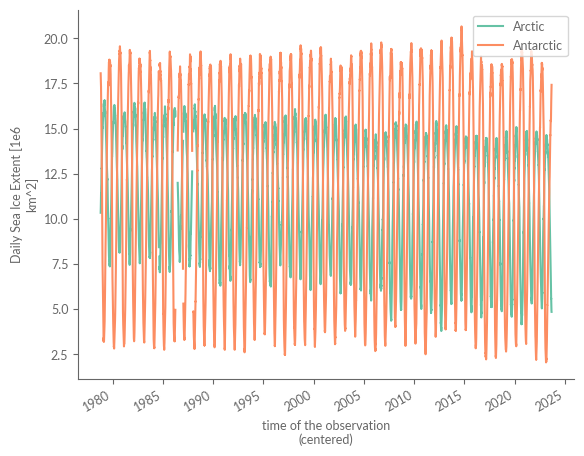

In [9]:
sie["Arctic"].plot(label="Arctic")
sie["Antarctic"].plot(label="Antarctic")
plt.legend()

In [10]:
sie["year"] = sie.time.dt.year
sie["dayofyear"] = sie.time.dt.dayofyear
sie = sie.set_index(time=["year", "dayofyear"]).unstack()
sie


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:    (year: 46, dayofyear: 366)
Coordinates:
  * year       (year) int64 1978 1979 1980 1981 1982 ... 2020 2021 2022 2023
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    Arctic     (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan
    Antarctic  (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan

In [11]:
sie_clim_median = sie.sel(REF_YEARS).median("year")

In [12]:
def create_line_plot(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    # Plot the data as a line for each year
    xr.plot.line(data, ax=ax, x="dayofyear", color=".5", alpha=.5, add_legend=False)
    return fig, ax

def highlight_most_recent_year(ax, data):
    # Add the most recent year as a red line
    data.isel(year=-1).plot.line(ax=ax, x="dayofyear", color="r", alpha=.5, lw=4)
    # Add text with year at the most recent data point with the same color as the line
    most_recent_data = data.isel(year=-1).dropna('dayofyear').isel(dayofyear=-1)
    ax.text(
        most_recent_data.dayofyear + 5,
        most_recent_data.values,
        most_recent_data.year.values,
        color="r",
        alpha=.5,
        fontsize=14,
        weight="bold",
        va="center",
    )
    # Mark the most recent data with a red circle
    ax.plot(
        most_recent_data.dayofyear,
        most_recent_data.values,
        "o",
        color="r",
        alpha=.75,
        markersize=10,
        markeredgewidth=0,
    )

def center_labels_between_xticks(ax):
    # set y-ticks as integers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Set major x-ticks every 1 month
    ax.xaxis.set_major_locator(dates.MonthLocator())


    # Centering labels between ticks
    # 16 is a slight approximation since months differ in number of days.
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter("%b"))

    # Remove the minor tick lines
    ax.tick_params(axis="x", which="minor", tick1On=False, tick2On=False)

    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment("center")

In [13]:
region = 'Antarctic'

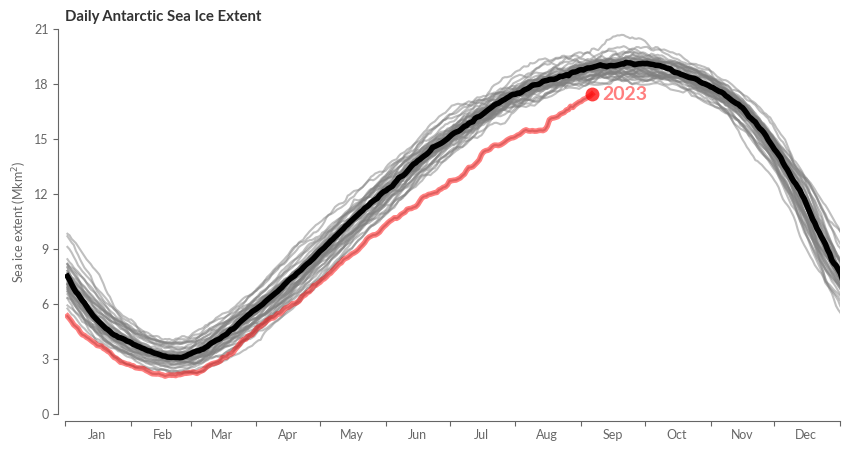

In [14]:
fig, ax = create_line_plot(sie[region])
# Add the median as a bold black line
sie_clim_median[region].plot(ax=ax, color="k", alpha=1, lw=4)
highlight_most_recent_year(ax, sie[region])
center_labels_between_xticks(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, 21)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent", weight='bold')
ax.set_ylabel("Sea ice extent (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()



In [15]:
sie_anomaly = sie - sie_clim_median

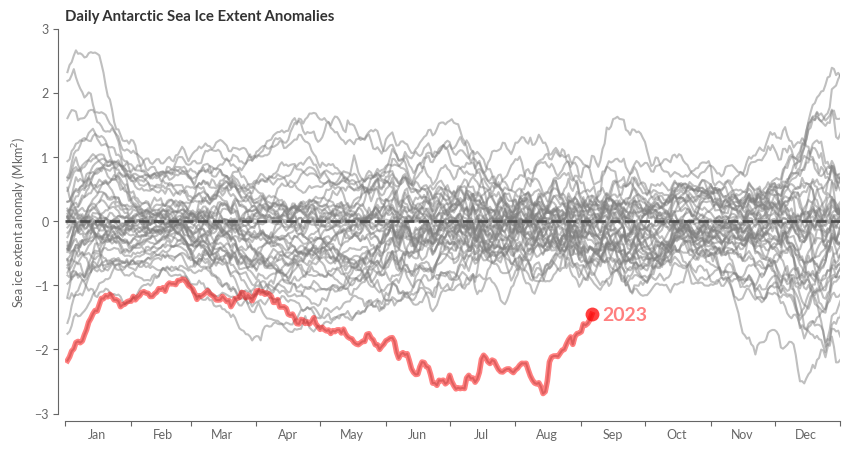

In [16]:
fig, ax = create_line_plot(sie_anomaly[region])
highlight_most_recent_year(ax, sie_anomaly[region])
center_labels_between_xticks(ax)
# Add center line
ax.axhline(0, color=".3", linewidth=0.5, ls='--', lw=2)
ax.set_xlim(0, 365)
ax.set_ylim(-3, 3)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent Anomalies", weight="bold")
ax.set_ylabel("Sea ice extent anomaly (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()


### Sea Ice Concentration
[CDS Data Access](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview)

In [6]:
DAYS = ["{:02d}".format(d) for d in range(1, 32)]
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3, 9]]  # Note: only Feb, Mar and Sep are downloaded
YEARS = ["{:04d}".format(y) for y in range(1979, 2023)]


Note: We only download daily sea ice concentration for February, March and September which is sufficient to reproduce the Climate Indicator figures. However, you may be interested in other months too, so don"t hesitate to download more months if your environment provides sufficient space to store the data.

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    As the time of writing, the Climate Data Store provides access to version 2 of the dataset and not the most recent version 3. If you need version 3, please consider downloading directly from <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>

In [7]:
def download_sea_ice_concentration(client, year, month, save_to):
    client.retrieve(
        "satellite-sea-ice-concentration",
        {
            "version": "v2",
            "variable": "all",
            "format": "tgz",
            "origin": "eumetsat_osi_saf",
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
        },
        save_to,
    )
    # Unzip and then remove zipped file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


In [8]:
client = cdsapi.Client(quiet=True, progress=False)

<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
    The following cell will download about 33 GB. Please be sure that you have enough space available. Depending on your broadband internet connection this may take up to several hours.
</div>

In [ ]:
for year in tqdm(YEARS, desc="Overall progress"):
    for month in tqdm(MONTHS, desc="Year {}".format(year), leave=False):
        # Define the filename and the path to save the file
        filename = f"EUMETSAT_OSI_SAF_SIC_{year}_{month}.tar.gz"
        save_to = os.path.join(path_to["concentration"], filename)
        # Check if the extracted files already exist
        files_in_dir = glob.glob(f"data/concentration/*{year}{month}*.nc")
        skip_file = len(files_in_dir) > 0
        # Download the file if it doesn"t exist
        if not skip_file:
            download_sea_ice_concentration(client, year, month, save_to)

In [9]:
def download_c3s_sea_ice_type(client, variable, year, month, save_to):
    """Download sea ice edge/type for a given year and month from the CDS."""

    client.retrieve(
        "satellite-sea-ice-edge-type",
        {
            "format": "tgz",
            "variable": [variable],  # one of ["sea_ice_edge", "sea_ice_type",],  
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
            "version": "2_0",
        },
        save_to
    )
    # Unzip and then remove zipped file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


def download_loop(client, variable, years, months):
    for year in tqdm(years, desc="Overall progress"):
        for month in tqdm(months, desc="Year {}".format(year), leave=False):
            # Define the filename and the path to save the file
            filename = f"EUMETSAT_OSI_SAF_{year}_{month}.tar.gz"
            save_to = os.path.join(path_to[variable], filename)
            # Check if the extracted files already exist
            path_dir = os.path.dirname(save_to)
            file_name_pattern = os.path.join(path_dir, f"*{year}{month}*.nc")
            # Get all files in the directory that match the pattern
            files_in_dir = glob.glob(file_name_pattern)
            file_already_exists = len(files_in_dir) > 0
            # Download the file if it doesn't existEdge

In [ ]:
download_loop(client=client, variable='sea_ice_edge', years=YEARS, months=MONTHS)

In [21]:
da = xr.open_dataset("data/concentration/ice_conc_nh_ease2-250_icdr-v2p0_202209301200.nc")
da

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 2022-09-30T12:00:00
  * xc                        (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                        (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_conc                  (time, yc, xc) float64 ...
    raw_ice_conc_values       (time, yc, xc) float64 ...
    total_standard_error      (time, yc, xc) float64 ...
    smearing_standard_error   (time, yc, xc) float64 ...
    algorithm_standard_error  (time, yc, xc) float64 ...
    status_flag               (time, yc, xc) float32 ...
Attributes: (12/41)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.62393
    ...                        ...
    tracking_id:               40d1b998-ea2b-4d1e-b761-0b501e06448c
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v65, 09 April 2019)
    product_id:                osi-430-b
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            demonstration

In [10]:
def return_sic_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_conc']

In [11]:
sic = xr.open_mfdataset(path_to['ice_conc'] + "/*.nc", preprocess=return_sic_only)
sic

<xarray.Dataset>
Dimensions:   (time: 3735, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [16]:
def interpolate_daily(da):
    months = np.unique(da.time.dt.month)
    # Create a daily time index
    daily_index = xr.date_range(start=da.time[0].values,end=da.time[-1].values, freq='D')
    # Only consider the months that are in the data
    daily_index = daily_index[daily_index.month.isin(months)]
    # Reindex the data to the daily time index
    da_reindexed = da.reindex(time=daily_index).chunk(dict(time=-1, xc=50, yc=50))
    # Interpolate the missing values
    return da_reindexed.interpolate_na("time")

sic_interp = interpolate_daily(sic)
sic_interp

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:   (time: 5290, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(5290, 50, 50), meta=np.ndarray>

In [18]:
path_to_processed_sic = path_to['ice_conc_processed'] + "ice_conc_interpolated.nc"

with ProgressBar():
    sic_interp.to_netcdf(path_to_processed_sic)

[########################################] | 100% Completed | 281.96 s


In [26]:
chunks = dict(time=50, xc=-1, yc=-1)
with xr.open_mfdataset(path_to_processed_sic, chunks=chunks) as sic_interp:
    pass

In [27]:
sic_interp.coords

Coordinates:
  * time     (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03

In [28]:
sic_interp.coords.update({"xc": sic.xc * 1000, "yc": sic.yc * 1000})


In [29]:
is_covered = sic_interp['ice_conc'] >= 15
ice_extent = (is_covered * 25**2).sum(('yc', 'xc'))
ice_extent

<xarray.DataArray 'ice_conc' (time: 5290)>
dask.array<sum-aggregate, shape=(5290,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00

In [31]:
with ProgressBar():
    ice_extent = ice_extent.compute()
    


In [37]:
ice_extent_monthly = ice_extent.resample(time='1M').mean()

In [47]:
ice_extent_monthly_clim = ice_extent_monthly.sel(REF_PERIOD).groupby('time.month').mean('time')
ice_extent_monthly_anomaly = ice_extent_monthly.groupby('time.month') - ice_extent_monthly_clim

ice_extent_monthly_anomaly_relative = ice_extent_monthly_anomaly.groupby('time.month') / ice_extent_monthly_clim * 100 # in percent

In [55]:
month = 9

time_steps = ice_extent_monthly_anomaly_relative.time
data = ice_extent_monthly_anomaly_relative.sel(time=time_steps.dt.month == month)

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


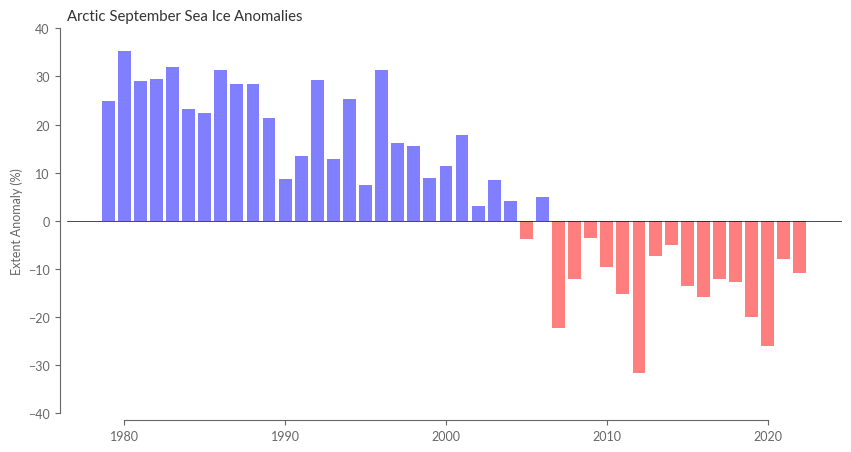

In [57]:
# define colors to be blue for positive and red for negative anomalies
colors = ['blue' if x >= 0 else 'red' for x in data]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.bar(data.time.dt.year, data, color=colors, alpha=.5)
ax.axhline(0, color='black', linewidth=.5)
ax.set_title('Arctic September Sea Ice Anomalies')
ax.set_ylabel('Extent Anomaly (%)')
ax.set_ylim(-40, 40)
sns.despine(ax=ax, offset=5, trim=True)
plt.show()

In [52]:
sic_monthly = sic_interp.resample(time='1M').mean()

In [53]:
with ProgressBar():
    sic_monthly = sic_monthly.compute()

[########################################] | 100% Completed | 22.12 s


In [54]:
sic_monthly_clim = sic_monthly.sel(REF_PERIOD).groupby('time.month').mean('time')
sic_monthly_anomaly = sic_monthly.groupby('time.month') - sic_monthly_clim
sic_monthly_anomaly

<xarray.Dataset>
Dimensions:   (xc: 432, yc: 432, time: 525)
Coordinates:
  * xc        (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * yc        (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * time      (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2022-09-30
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 11 12 1 2 3 4 5 6 7 8 9
Data variables:
    ice_conc  (time, yc, xc) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

### Sea Ice Edge

In [60]:
with xr.open_dataset("data/edge/ice_edge_nh_ease2-125_cdr-v2p0_197902011200.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:                 (time: 1, nv: 2, xc: 864, yc: 864)
Coordinates:
  * time                    (time) datetime64[ns] 1979-02-01T12:00:00
  * xc                      (xc) float64 -5.394e+03 -5.381e+03 ... 5.394e+03
  * yc                      (yc) float64 5.394e+03 5.381e+03 ... -5.394e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    time_bnds               (time, nv) datetime64[ns] ...
    ice_edge                (time, yc, xc) float32 ...
    uncertainty             (time, yc, xc) float32 ...
    status_flag             (time, yc, xc) float32 ...
Attributes: (12/43)
    title:                     Sea Ice Edge
    summary:                   Daily gridded Level-4 Sea Ice Edge Climate Dat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    ...                        ...
    processing_level:          Level-4 (l4)
    tracking_id:               7905b5d9-d8f8-4260-9edb-86bb27b88d8b
    doi:                       https://doi.org/10.24381/cds.29c46d83
    naming_authority:          no.met
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)

Again, the downloaded data set provides rich information about errors and uncertainties. However, we only consider the sea ice edge here, so we remove all additional variables that blow up the size of the data set.

In [61]:
def return_edge_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_edge']

In [89]:
ice_edge = xr.open_mfdataset(path_to['ice_edge'] + "/*.nc", preprocess=return_edge_only)
ice_edge

<xarray.Dataset>
Dimensions:   (time: 3524, xc: 864, yc: 864)
Coordinates:
  * time      (time) datetime64[ns] 1979-02-01T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.394e+03 -5.381e+03 ... 5.381e+03 5.394e+03
  * yc        (yc) float64 5.394e+03 5.381e+03 ... -5.381e+03 -5.394e+03
Data variables:
    ice_edge  (time, yc, xc) float32 dask.array<chunksize=(1, 864, 864), meta=np.ndarray>

In [91]:
ice_edge = ice_edge.chunk({'time': -1, 'xc': 50, 'yc': 50})
ice_edge.ice_edge

<xarray.DataArray 'ice_edge' (time: 3524, yc: 864, xc: 864)>
dask.array<rechunk-merge, shape=(3524, 864, 864), dtype=float32, chunksize=(3524, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.394e+03 -5.381e+03 ... 5.381e+03 5.394e+03
  * yc       (yc) float64 5.394e+03 5.381e+03 ... -5.381e+03 -5.394e+03
Attributes:
    long_name:            Classification of sea surface into the classes of o...
    standard_name:        sea_ice_classification
    valid_min:            1
    valid_max:            3
    grid_mapping:         Lambert_Azimuthal_Grid
    flag_values:          [1 2 3]
    flag_meanings:        open_water open_ice closed_ice
    flag_descriptions:    flag 1: No ice or very open ice (less than 30% ice ...
    ancillary_variables:  uncertainty status_flag
    comment:              this field is the primary sea ice edge estimate for...

In [92]:
ice_edge_ref_period = ice_edge.sel(time=ice_edge.time.dt.month == 9).sel(REF_PERIOD)

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [93]:
median_ice_edge = ice_edge_ref_period.median('time')
with ProgressBar():
    median_ice_edge = median_ice_edge.compute()


[#####################################   ] | 92% Completed | 97.84 ss

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[########################################] | 100% Completed | 168.45 s


In [96]:
median_ice_edge.coords.update({'xc': median_ice_edge.xc.values * 1000, 'yc': median_ice_edge.yc.values * 1000})

In [ ]:
edge_interp_monthly = edge_interp.resample(time='1M').mean()
edge_interp_monthly

In [ ]:
with ProgressBar():
    edge_interp_monthly = edge_interp_monthly.compute()[0].plot()

In [168]:
median_ice_edge = edge_interp_monthly.sel(time=slice('1991', '2020')).mean('time')
median_ice_edge.coords.update({'xc': median_ice_edge.xc.values * 1000, 'yc': median_ice_edge.yc.values * 1000})

In [97]:
def str2float(label):
    # Extract the numbers from the label
    number = ''.join(c for c in label if c.isdigit())
    number = float(number)
    # Longitude is negative if it is in the west of the meridian
    if 'W' in label:
        number = -number
    return number

def lon2rot(lon):
    rot_rad = lon
    if abs(lon) >= 90:
        rot_rad = lon - 180
    return rot_rad


def set_circle_boundary(ax):
    # Set a circle boundary for the map
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

def rotate_labels_polar_plot(ax, gridlines):
    # Rotate the labels to simplify reading them
    plt.draw()
    for label in ax.texts:
        alphanumeric_label = label.get_text()
        longitude = str2float(alphanumeric_label)
        if longitude in gridlines.xlocator.locs:
            rot_degree = lon2rot(longitude)
            label.set_rotation(rot_degree)
            label.set_horizontalalignment('center')
            label.set_verticalalignment('center')
            if abs(longitude) >= 90:
                label.set_verticalalignment('bottom')
            else:
                label.set_verticalalignment('top')
        else:
            label.set_visible(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


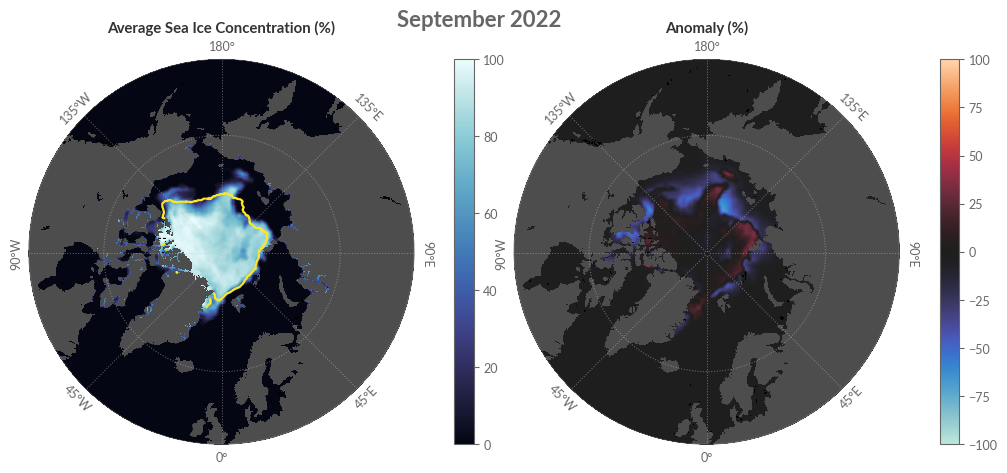

In [110]:


lon_formatter = LongitudeFormatter(
    number_format='.1f',
    degree_symbol='',
    dateline_direction_label=True
)
lat_formatter = LatitudeFormatter(
    number_format='.1f',
    degree_symbol=''
)

proj_polar = ccrs.NorthPolarStereo()
proj_data = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, .05, 1, .05])
ax1 = fig.add_subplot(gs[0, 0], projection=proj_polar)
ax2 = fig.add_subplot(gs[0, 2], projection=proj_polar)
cax1 = fig.add_subplot(gs[0, 1])
cax2 = fig.add_subplot(gs[0, 3])
axes = [ax1, ax2]
for ax in axes:
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    gl = ax.gridlines(zorder=5, ls=':', lw=.75, color='.75', alpha=.5, draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135, 180])
    gl.ylocator = mticker.FixedLocator([30, 65, 90])

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cfeature.OCEAN, zorder=1, color='k')
    ax.add_feature(cfeature.LAND, zorder=2, color='.3')

    set_circle_boundary(ax)

sic_cbar_kws = dict(label='')
sic_anom_cbar_kws = dict(label='')
sic_kws = dict(vmin=0, vmax=100, cmap=cmo.cm.ice, zorder=3, transform=proj_data, cbar_ax=cax1, cbar_kwargs=sic_cbar_kws)
sic_anom_kws = dict(vmin=-100, vmax=100, cmap='icefire', zorder=3, transform=proj_data, cbar_ax=cax2, cbar_kwargs=sic_anom_cbar_kws)
sic_monthly['ice_conc'].isel(time=-1).plot.pcolormesh(ax=ax1, **sic_kws)
sic_monthly_anomaly['ice_conc'].isel(time=-1).plot.pcolormesh(ax=ax2, **sic_anom_kws)

# Add the median ice edge as a yellow contour line
cp = median_ice_edge['ice_edge'].plot.contour(ax=ax1, levels=[2], transform=proj_data, zorder=5)
labels = ['1991-2020 median ice edge']

for ax in axes:
    ax.set_title('')
    # Rotate the labels to simplify reading them
    rotate_labels_polar_plot(ax, gl)

ax1.legend(loc='lower left', bbox_to_anchor=(-.05, -0.05), frameon=False)
ax1.set_title('Average Sea Ice Concentration (%)', weight='bold', loc='center')
ax2.set_title('Anomaly (%)', weight='bold', loc='center')
fig.suptitle('September 2022', weight='bold', fontsize=16)
plt.show()

In [127]:
sic_september = sic_monthly.sel(time=(sic_monthly.time.dt.month == 9))

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [128]:
polyfit = sic_september.polyfit('time', 1)
polyfit

<xarray.Dataset>
Dimensions:                        (yc: 432, xc: 432, degree: 2)
Coordinates:
  * yc                             (yc) float64 5.388e+06 ... -5.388e+06
  * xc                             (xc) float64 -5.388e+06 ... 5.388e+06
  * degree                         (degree) int64 1 0
Data variables:
    ice_conc_polyfit_coefficients  (degree, yc, xc) float64 0.0 0.0 ... nan nan

In [129]:
trend = polyfit.ice_conc_polyfit_coefficients.sel(degree=1)
# Convert from 1/s to 1/decade
trend = (trend * 1.e9 * 60 * 60 * 24 * 365 * 10)

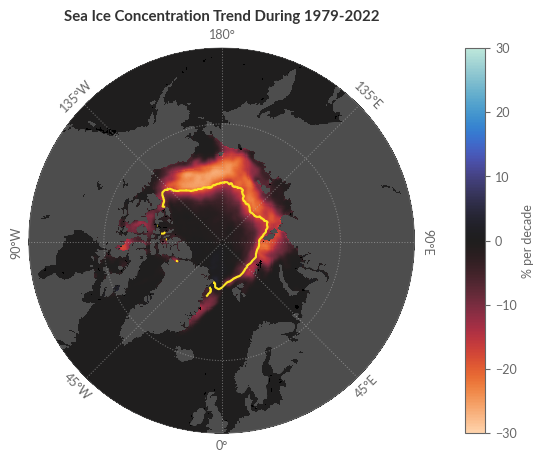

In [132]:
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, .05])
ax1 = fig.add_subplot(gs[0, 0], projection=proj_polar)
cax1 = fig.add_subplot(gs[0, 1])
axes = [ax1]
for ax in axes:
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    gl = ax.gridlines(zorder=5, ls=':', lw=.75, color='.75', alpha=.5, draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135, 180])
    gl.ylocator = mticker.FixedLocator([30, 65, 90])

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cfeature.OCEAN, zorder=1, color='k')
    ax.add_feature(cfeature.LAND, zorder=2, color='.3')

    set_circle_boundary(ax)

bla_cbar_kws = dict(label='% per decade')
bla_kws = dict(vmin=-30, vmax=30, cmap='icefire_r', zorder=3, transform=proj_data, cbar_ax=cax1, cbar_kwargs=bla_cbar_kws)
trend.plot.pcolormesh(ax=ax1, **bla_kws)
cp = median_ice_edge["ice_edge"].plot.contour(ax=ax1, levels=[2], transform=proj_data, zorder=5)
labels = ['1991-2020 median ice edge']


for ax in axes:
    ax.set_title('')
    # Rotate the labels to simplify reading them
    rotate_labels_polar_plot(ax, gl)

ax1.set_title('Sea Ice Concentration Trend During 1979-2022', weight='bold', loc='center')
plt.show()

### Sea Ice Type
[CDS Data Access](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=overview)

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    As the time of writing, the Climate Data Store provides access to version 2 of the dataset and not the most recent version 3. If you need version 3, please consider downloading directly from <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>

In [ ]:
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3]]  # Note: only Jan-Mar are downloaded
download_loop(client=client, variable='sea_ice_type', years=YEARS, months=MONTHS)

In [134]:
with xr.open_dataset("data/type/ice_type_nh_ease2-250_cdr-v2p0_197902011200.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:                 (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                    (time) datetime64[ns] 1979-02-01T12:00:00
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    time_bnds               (time, nv) datetime64[ns] ...
    ice_type                (time, yc, xc) float32 ...
    uncertainty             (time, yc, xc) float32 ...
    status_flag             (time, yc, xc) float32 ...
Attributes: (12/44)
    title:                     Sea Ice Type
    summary:                   Daily gridded Level-4 Sea Ice Type Climate Dat...
    comment:                   Northern Hemisphere sea ice type classificatio...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    ...                        ...
    processing_level:          Level-4 (l4)
    tracking_id:               43552121-b502-4672-877e-4807b5f50fb5
    doi:                       https://doi.org/10.24381/cds.29c46d83
    naming_authority:          no.met
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)

In [135]:
def return_type_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_type']

In [136]:
ice_type = xr.open_mfdataset(path_to['ice_type'] + "/*.nc", preprocess=return_type_only)
ice_type

<xarray.Dataset>
Dimensions:   (time: 3376, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-03-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables:
    ice_type  (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [158]:
common_time_steps = sic.ice_conc.time.to_index().intersection(ice_type.ice_type.time.to_index())
sic_spring = sic["ice_conc"].sel(time=common_time_steps)
ice_type_spring = ice_type["ice_type"].sel(time=common_time_steps)

In [218]:
ice_area_spring = (sic_spring / 100 * 25**2)

In [219]:
is_seasonal_ice = ice_type_spring == 2
is_multiyear_ice = ice_type_spring == 3
is_ambiguous_ice = ice_type_spring == 4
ice_categories = xr.concat([is_seasonal_ice, is_multiyear_ice, is_ambiguous_ice], dim="ice_type")
ice_categories.coords.update({"ice_type": ["seasonal", "multiyear", "ambiguous"]})
ice_categories


<xarray.DataArray 'ice_type' (ice_type: 3, time: 2539, yc: 432, xc: 432)>
dask.array<concatenate, shape=(3, 2539, 432, 432), dtype=bool, chunksize=(1, 1, 432, 432), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-03-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * ice_type  (ice_type) <U9 'seasonal' 'multiyear' 'ambiguous'

Now, we compute the total sea ice extent by sea ice type. For this, we need the daily **sea ice area** per grid cell and the corresponding sea ice type. The sea ice area is obtained by multiplying grid cell areas by their corresponding sea ice concentration. Then we can sum up the sea ice area for each sea ice type and each day, which can be represented as a dot product over the spatial dimensions `xc` and `yc`:

In [220]:
average_ice_types = xr.dot(
    ice_area_spring.fillna(0),
    ice_categories,
    dims=['xc', 'yc']
)

Let's compute the `DataArray`:

In [221]:
with ProgressBar():
    average_ice_types = average_ice_types.compute()

[########################################] | 100% Completed | 89.43 s


Now, let's compute the average sea ice extent for each year by calculating the monthly average and then the mean over the months:

In [236]:
ice_extent_by_type = average_ice_types.resample(time='1M').mean()
ice_extent_by_type = ice_extent_by_type.groupby('time.year').mean('time')
ice_extent_by_type.name = 'ice_extent'

We convert the sea ice extent to million square kilometers:

In [237]:
ice_extent_by_type = ice_extent_by_type / 1.e6  # convert to Mkm^2

For visualising, we will bring the data into a form that is more convenient for plotting. For this, we will make use of `to_dateframe` method to convert the `sea_ice_extent` DataArray into a `pandas.DataFrame`:

In [290]:
ice_extent_df = ice_extent_by_type.to_dataframe().unstack('ice_type')['ice_extent']
rel_ice_extent_df = ice_extent_df.div(ice_extent_df.sum(axis=1), axis=0) * 100

In [353]:
most_recent_data = ice_type['ice_type'].sel(time=slice('2022-01-01', '2022-03-31')).median('time')
most_recent_data = most_recent_data.compute()
most_recent_data.coords.update({"xc": most_recent_data.xc.values * 1000, "yc": most_recent_data.yc.values * 1000})

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


In [385]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = sns.color_palette("tab10", n_colors=5)

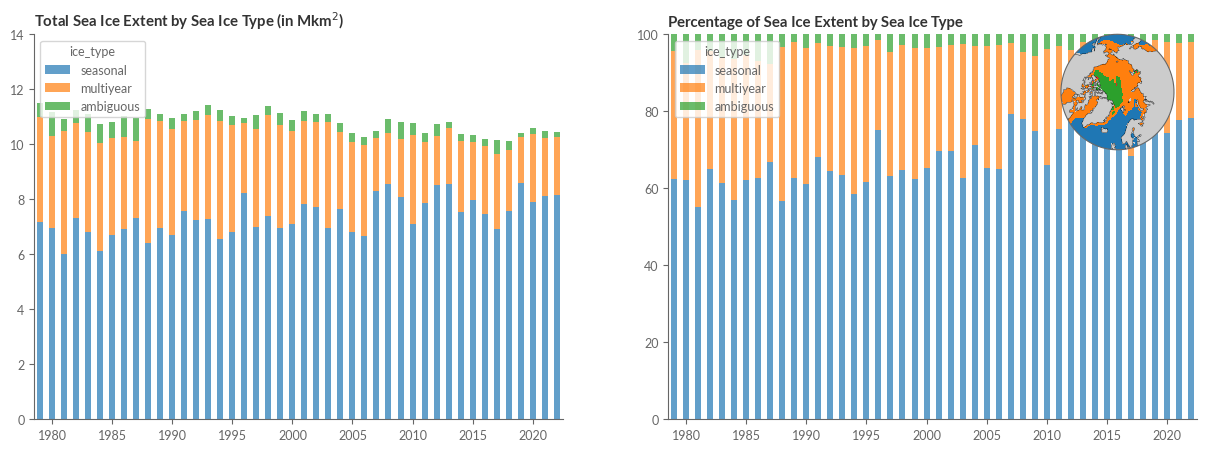

In [398]:
pad  = 0.0
w = 0.3
h = 0.3
n_years = ice_extent_df.shape[0]
xticks = np.arange(1, n_years, 5)
xticklabels = ice_extent_df.index[xticks]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ice_extent_df.plot.bar(ax=ax1, stacked=True, xticks=xticks, color=colors, alpha=.7)
rel_ice_extent_df.plot.bar(ax=ax2, stacked=True, xticks=xticks, color=colors, alpha=.7)
for ax in [ax1, ax2]:
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Ice extent (Mkm$^2$)')
    sns.move_legend(ax, "upper left")

ax1.set_ylim(0, 14)
ax2.set_ylim(0, 100)

ax1.set_title('Total Sea Ice Extent by Sea Ice Type (in Mkm$^2$)', weight='bold')
ax2.set_title('Percentage of Sea Ice Extent by Sea Ice Type (in %)', weight='bold')

ax1.set_ylabel('')
ax2.set_ylabel('')

# Add a mini map of the Arctic to the upper right corner
a = ax2.get_position()
axins = fig.add_axes([a.x1-(w+pad)*a.width,a.y1-(h+pad)*a.height,w*a.width,h*a.height], projection=proj_polar)
axins.add_feature(cfeature.LAND, zorder=1, color='.8')
axins.coastlines('110m', lw=.25)
axins.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
most_recent_data.plot.contourf(ax=axins, transform=proj_data, add_colorbar=False, levels=[1.5, 2.5, 3.5], colors=colors)
set_circle_boundary(axins)